<a href="https://colab.research.google.com/github/RagozinaMarina/toxic/blob/master/toxic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import libraries
import re
import string
import numpy as np
import pandas as pd
from plotly import graph_objs as go
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

Saving kaggle.json to kaggle.json


In [5]:
! kaggle datasets download -d reihanenamdari/youtube-toxicity-data
! unzip youtube-toxicity-data.zip -d youtube-toxicity-data

  0% 0.00/96.8k [00:00<?, ?B/s]
100% 96.8k/96.8k [00:00<00:00, 64.3MB/s]
Archive:  youtube-toxicity-data.zip
  inflating: youtube-toxicity-data/youtoxic_english_1000.csv  


In [ ]:
# ! kaggle competitions download -c jigsaw-multilingual-toxic-comment-classification
# ! unzip jigsaw-multilingual-toxic-comment-classification.zip -d jigsaw-multilingual-toxic-comment-classification

 99% 1.07G/1.08G [00:11<00:00, 117MB/s]
100% 1.08G/1.08G [00:11<00:00, 104MB/s]
Archive:  jigsaw-multilingual-toxic-comment-classification.zip
  inflating: jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv  
  inflating: jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv  
  inflating: jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv  
  inflating: jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv  
  inflating: jigsaw-multilingual-toxic-comment-classification/sample_submission.csv  
  inflating: jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv  
  inflating: jigsaw-multilingual-toxic-comment-classification/test.csv  
  inflating: jigsaw-multilingual-toxic-comment-classification/test_labels.csv  
  inflating: jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv  
  

In [6]:
# import data
data = pd.read_csv('/content/youtube-toxicity-data/youtoxic_english_1000.csv')

In [7]:
data

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Ugi5ADt10EdDz3gCoAEC,XRuCW80L9mA,I remember that they sent in the national defe...,False,False,False,False,False,False,False,False,False,False,False,False
996,Ugifh2DMhBbDkHgCoAEC,XRuCW80L9mA,Stats don`t represent the problem. Race baitin...,True,False,False,False,False,True,True,False,False,False,False,False
997,Ugj_plbGBjjzYXgCoAEC,XRuCW80L9mA,The quote from the mother... Wow that hit hard...,False,False,False,False,False,False,False,False,False,False,False,False
998,Ugj0bah1De8xy3gCoAEC,XRuCW80L9mA,this video is so racist,False,False,False,False,False,False,False,False,False,False,False,False


In [9]:
data.Text

0      If only people would just take a step back and...
1      Law enforcement is not trained to shoot to app...
2      \nDont you reckon them 'black lives matter' ba...
3      There are a very large number of people who do...
4      The Arab dude is absolutely right, he should h...
                             ...                        
995    I remember that they sent in the national defe...
996    Stats don`t represent the problem. Race baitin...
997    The quote from the mother... Wow that hit hard...
998                              this video is so racist
999        God, the narrator has such an annoying lisp. 
Name: Text, Length: 1000, dtype: object

In [8]:
balance_counts = data.groupby('IsToxic')['IsToxic'].agg('count').values

In [10]:
# show dataset distribution
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['non_toxic'],
    y=[balance_counts[0]],
    name='non_toxic',
    text=[balance_counts[0]],
    textposition='auto'
))
fig.add_trace(go.Bar(
    x=['toxic'],
    y=[balance_counts[1]],
    name='toxic',
    text=[balance_counts[1]],
    textposition='auto'
))
fig.update_layout(
    title='<span>Toxicity distribution</span>'
)
fig.show()

In [11]:
data['message_len'] = data['Text'].apply(lambda x: len(x.split(' ')))
data.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism,message_len
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False,286
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False,25
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False,77
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False,107
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False,47


In [12]:
toxic = data[data['IsToxic'] == True]['message_len'].value_counts().sort_index()
non_toxic = data[data['IsToxic'] == False]['message_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=toxic.index,
    y=toxic.values,
    name='toxic'
))
fig.add_trace(go.Scatter(
    x=non_toxic.index,
    y=non_toxic.values,
    name='non_toxic'
))
fig.update_layout(
    title='<span>Toxicity and length of text</span>'
)
fig.update_xaxes(range=[0, 140])
fig.show()

In [13]:
stop_words = stopwords.words('english')
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    # text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [14]:
data['message_clean'] = data['Text'].apply(preprocess_data)
data.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism,message_len,message_clean
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False,286,people would take step back make case wasnt an...
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False,25,law enforcement trained shoot apprehend they ...
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False,77,dont reckon black lives matter banners held w...
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False,107,large number people like police officers calle...
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False,47,arab dude absolutely right shot extra time sh...


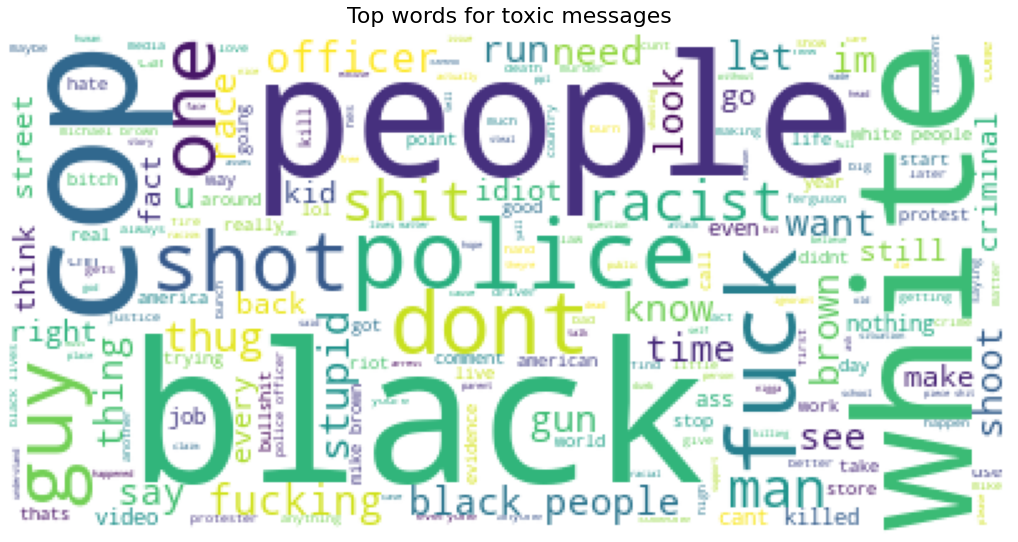

In [15]:
wc = WordCloud(
    background_color='white', 
    max_words=200
)
wc.generate(' '.join(text for text in data.loc[data['IsToxic'] == True, 'message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for toxic messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

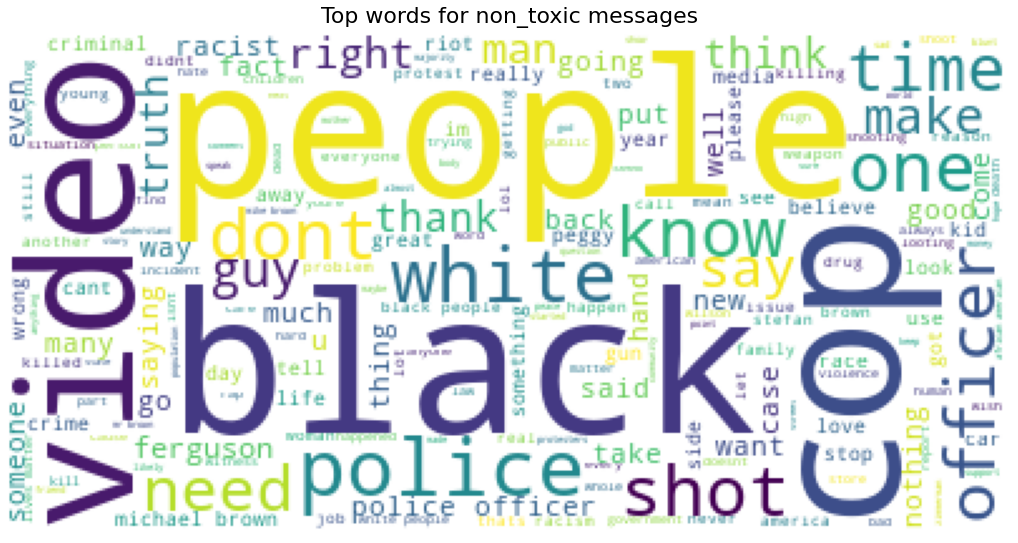

In [16]:
wc = WordCloud(
    background_color='white', 
    max_words=200
)
wc.generate(' '.join(text for text in data.loc[data['IsToxic'] == False, 'message_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for non_toxic messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [17]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data["classes"] = le.fit_transform(data['IsToxic'])

In [18]:
data["classes"]

0      0
1      1
2      1
3      0
4      0
      ..
995    0
996    1
997    0
998    0
999    0
Name: classes, Length: 1000, dtype: int64

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data.message_clean, data['classes'], test_size=0.5, random_state=0)

In [18]:
x_test

993    whites moveout ferguson lets see nice becomes ...
859    michael brown thug god bless thin blue line gr...
298    want shoot hardly wait till one kids gets trou...
553    finland population  million police force  poli...
672                ever get situation run assholes overi
                             ...                        
647                                         ran everyone
190    someone say way black people behave wonder fer...
361    omg stefan rap hysterical anyway good news gue...
664                        runem theyre freaking freeway
375                                   gentle gentl giant
Name: message_clean, Length: 500, dtype: object

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_transformer = TfidfVectorizer()

tfidf_transformer.fit(x_train)

TfidfVectorizer()

In [20]:
y_test

993    1
859    1
298    1
553    0
672    1
      ..
647    1
190    1
361    1
664    1
375    0
Name: classes, Length: 500, dtype: int64

In [21]:
# Use the trained to create a document-term matrix from train and test sets
x_train_emb = tfidf_transformer.transform(x_train)
x_test_emb = tfidf_transformer.transform(x_test)

In [22]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(x_train_emb.toarray(), y_train)
score = gnb.score(x_test_emb.toarray(), y_test)
print(score)

0.61


In [22]:
import spacy
spacy_processor = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [23]:
def normalize_text(text, lemmatize=True, to_lower=True, transform_digits=True, only_alpha=False):
    if isinstance(text, list):
        processed_texts = list(spacy_processor.pipe(text))
        return [normalize_text(elem, lemmatize=lemmatize, to_lower=to_lower,
                               transform_digits=transform_digits, only_alpha=only_alpha) 
                for elem in processed_texts] 
    elif isinstance(text, str):
        processed_text = spacy_processor(text)
    else:  ## type(text) = Spacy.Doc
        processed_text = text
    if lemmatize:
        answer = [token.lemma_ if token.lemma_ != "-PRON-" else token.text.lower() for token in processed_text]
    else:
        answer = [token.text for token in processed_text]
    if to_lower:
        answer = [x.lower() for x in answer]
    if only_alpha:
        answer = [x for x in answer if x.isalpha() or x.isdigit()]
    if transform_digits:
        answer = ['<DIGIT>' if x.isdigit() else x for x in answer]
    return answer

In [21]:
from sklearn.model_selection import train_test_split

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=0)

In [29]:
x_train

631    law wont prosecuted run people blocking street...
185    perhaps start teaching blacks law education im...
732     love woman voice matters fuck black lives matter
404    loved trayvon martin video love one wish could...
194                                    bill cosby caused
                             ...                        
835              thank speaking problems black community
192                                something wrong voice
629                                 black lives splatter
559    guess misread joe  ever seen anyone put place ...
684          dont get arent protesting like wrong people
Name: message_clean, Length: 500, dtype: object

In [ ]:
train_texts = normalize_text(x_train.tolist(), lemmatize=False)
val_texts = normalize_text(x_val.tolist(), lemmatize=False)
test_texts = normalize_text(x_test.tolist(), lemmatize=False)

In [25]:
from collections import defaultdict

class Vocabulary:

    def __init__(self, add_begin=True, add_end=True, min_count=1):
        self.add_begin = add_begin
        self.add_end = add_end
        self.min_count = min_count

    def fit(self, data):
        # специальные символы
        self.symbols_ = ["<PAD>", "<UNK>", "<BEGIN>", "<END>"]
        symbol_counts = defaultdict(int)
        for text in data:
            for letter in set(text):
                symbol_counts[letter] += 1
        self.symbols_ += [letter for letter, count in symbol_counts.items() if count >= self.min_count]
        self.symbol_codes_ = {letter: index for index, letter in enumerate(self.symbols_)}
        return self

    @property
    def unk(self):
        return self.symbol_codes_["<UNK>"]

    @property
    def begin(self):
        return self.symbol_codes_["<BEGIN>"]

    @property
    def end(self):
        return self.symbol_codes_["<END>"]

    def __call__(self, data):
        if isinstance(data, list) and not isinstance(data[0], str):
            return [self.__call__(text) for text in data]
        # data --- это отдельный текст
        indexes = [self.symbol_codes_.get(symbol, self.unk) for symbol in data]
        if self.add_begin:
            indexes = [self.begin] + indexes
        if self.add_end:
            indexes = indexes + [self.end]
        return indexes

In [26]:
vocab = Vocabulary(min_count=3).fit(train_texts)
X_train = vocab(train_texts)
X_val = vocab(val_texts)
X_test = vocab(test_texts)
print(f"{len(vocab.symbols_)} words in vocabulary.")
print("Example encoding", X_test[-1])

729 words in vocabulary.
Example encoding [2, 89, 90, 14, 222, 223, 168, 1, 366, 297, 1, 1, 3]


In [27]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder().fit(y_train)
Y_train = label_encoder.transform(y_train)
Y_val = label_encoder.transform(y_val)
Y_test = label_encoder.transform(y_test)

In [28]:
import torch
import numpy as np
import itertools

def pad_tensor(vec, length, dim, pad_symbol):
    # vec.shape = [3, 4, 5]
    # length=7, dim=1 -> pad_size = (3, 7-4, 5)
    pad_size = list(vec.shape)
    pad_size[dim] = length - vec.shape[dim]
    answer = torch.cat([vec, torch.ones(*pad_size, dtype=torch.long) * pad_symbol], axis=dim)
    return answer

def pad_tensors(tensors, pad=0):
    # дополняет тензоры из tensors до общей максимальной длины символом pad
    tensors = [torch.LongTensor(tensor) for tensor in tensors]
    L = max(tensor.shape[0] for tensor in tensors)
    tensors = [pad_tensor(tensor, L, dim=0, pad_symbol=pad) for tensor in tensors]
    return torch.stack(tensors, axis=0)

class BatchDataLoader:

    def __init__(self, X, Y=None, batch_size=32, sort_by_length=True, state=115, device="cpu"):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.sort_by_length = sort_by_length
        self.device = device
        np.random.seed(state)

    def __len__(self):
        return (len(self.X)-1) // self.batch_size + 1 

    def __iter__(self):
        if self.sort_by_length:
            # отсортировать индексы по длине объектов [1, ..., 32] -> [7, 4, 15, ...]
            order = np.argsort([len(x) for x in self.X])
            # сгруппировать в батчи [7, 4, 15, 31, 3, ...] -> [[7, 4, 15, 31], [3, ...], ...]
            batched_order = np.array([order[start:start+self.batch_size] 
                                      for start in range(0, len(self.X), self.batch_size)])
            # переупорядочить батчи случайно: [[3, 11, 21, 19], [27, ...], ..., [7, ...], ...]
            np.random.shuffle(batched_order[:-1])
            # собрать посл-ть индексов: -> [3, 11, 21, 19, 27, ...]
            self.order = np.fromiter(itertools.chain.from_iterable(batched_order), dtype=int)
        else:
            self.order = np.arange(len(self.X))
            np.random.shuffle(self.order)
        self.idx = 0
        return self

    def __next__(self):
        if self.idx >= len(self.X):
            raise StopIteration()
        end = min(self.idx + self.batch_size, len(self.X))
        indexes = [self.order[i] for i in range(self.idx, end)]
        X_to_return = pad_tensors([self.X[i] for i in indexes]).to(self.device)
        answer = {"X": X_to_return, "indexes": indexes}
        if self.Y is not None:
            Y_to_return = torch.LongTensor([self.Y[i] for i in indexes]).to(self.device)
            answer["Y"] = Y_to_return
        self.idx = end
        return answer

In [29]:
train_dataloader = BatchDataLoader(x_train, Y_train)
dev_dataloader = BatchDataLoader(x_val, Y_val)
test_dataloader = BatchDataLoader(x_test)

In [30]:
import torch
import torch.nn as nn

class BasicNeuralClassifier(nn.Module):

    def __init__(self, vocab_size, labels_number, device="cpu", **kwargs):
        super(BasicNeuralClassifier, self).__init__()
        self.vocab_size = vocab_size
        self.labels_number = labels_number
        self.build_network(vocab_size, labels_number, **kwargs)
        # определяем функцию потерь
        self.criterion = nn.NLLLoss(reduction="mean")
        self.device = device
        if self.device is not None:
            self.to(self.device)
        self.optimizer = torch.optim.Adam(self.parameters())

    def build_network(self, **kwargs):
        raise NotImplementedError("You should implement network construction in your derived class.")

    def forward(self, inputs):
        raise NotImplementedError("You should implement forward pass in your derived class.")

    def train_on_batch(self, x, y):
        self.train()
        self.optimizer.zero_grad()
        loss = self._validate(x, y)
        loss["loss"].backward()
        self.optimizer.step()
        return loss

    def validate_on_batch(self, x, y):
        self.eval()
        with torch.no_grad():
            return self._validate(x, y)

    def _validate(self, x, y):
        if self.device is not None:
            x, y = x.to(self.device), y.to(self.device)
        log_probs = self(x) #   self.forward(x) = self.__call__(x)
        loss = self.criterion(log_probs, y)
        _, labels = torch.max(log_probs, dim=1)
        return {"loss": loss, "labels": labels}

In [31]:
import torch
import torch.nn as nn

class AverageClassifier(BasicNeuralClassifier):

    def build_network(self, vocab_size, labels_number, embeddings_dim=32):
        self.embedding = nn.Embedding(vocab_size, embeddings_dim, padding_idx=0)
        self.dense = nn.Linear(embeddings_dim, labels_number)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, inputs, hidden_inputs=None):
        if self.device is not None:
            inputs = inputs.to(self.device)
        embeddings = self.embedding(inputs)
        # покоординатное усреднение
        text_embedding = torch.mean(embeddings, axis=1)
        # финальный слой
        logits = self.dense(text_embedding)
        log_probs = self.log_softmax(logits)
        return log_probs

In [32]:
model = AverageClassifier(vocab_size=len(vocab.symbols_), labels_number=len(label_encoder.classes_), 
                          embeddings_dim=128, device="cuda")
for name, elem in model.named_parameters():
    print(name, elem.device, elem.shape)

embedding.weight cuda:0 torch.Size([729, 128])
dense.weight cuda:0 torch.Size([2, 128])
dense.bias cuda:0 torch.Size([2])


In [33]:
train_batch_loader = BatchDataLoader(X_train, Y_train, batch_size=64, device="cuda:0")
for batch in train_batch_loader:
    x, y = batch["X"], batch["Y"]
    for i in range(50):
        loss = model.train_on_batch(x, y)["loss"].item()
        if i < 5 or (i+1) % 10 == 0:
            print(i, loss)
    print(model.validate_on_batch(x, y)["loss"].item())
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



0 0.7053179144859314
1 0.7007254362106323
2 0.6962950229644775
3 0.6920041441917419
4 0.6878161430358887
9 0.6674183011054993
19 0.6269000172615051
29 0.584663987159729
39 0.5387129187583923
49 0.48862606287002563
0.48341718316078186


In [34]:
train_dataloader = BatchDataLoader(X_train, Y_train, device="cuda:0")
val_dataloader = BatchDataLoader(X_val, Y_val, device="cuda:0")
test_dataloader = BatchDataLoader(X_test, device="cuda:0")
NEPOCHS = 35

In [35]:
def update_metrics(metrics, batch_output, batch_labels):
    n_batches = metrics["n_batches"]
    metrics["loss"] = (metrics["loss"] * n_batches + batch_output["loss"].item()) / (n_batches + 1)
    metrics["n_batches"] += 1
    are_equal = (batch_output["labels"] == batch_labels).cpu().numpy().astype("int")
    metrics["correct"] += are_equal.sum()
    metrics["total"] += are_equal.shape[0]
    metrics["accuracy"] = metrics["correct"] / max(metrics["total"], 1)

In [36]:
import tqdm

def do_epoch(model, dataloader, mode="validate", epoch=1):
    metrics = {"correct": 0, "total": 0, "loss": 0.0, "n_batches": 1}
    func = model.train_on_batch if mode == "train" else model.validate_on_batch
    progress_bar = tqdm.notebook.tqdm(dataloader, leave=True)
    progress_bar.set_description(f"{mode}, epoch={epoch}")
    for batch in progress_bar:
        batch, batch_answers = batch["X"], batch["Y"]
        batch_output = func(batch, batch_answers)
        update_metrics(metrics, batch_output, batch_answers)
        progress_bar.set_postfix({"loss": round(metrics["loss"], 4), "acc": round(100 * metrics["accuracy"], 2)})
    return metrics

In [37]:
# model = AverageClassifier(vocab_size=len(vocab.symbols_), labels_number=len(label_encoder.classes_), 
#                           embeddings_dim=200, device="cuda")
best_val_acc = 0.0
checkpoint = "checkpoint_best.pt"
for epoch in range(NEPOCHS):
    do_epoch(model, train_dataloader, mode="train", epoch=epoch+1)
    epoch_metrics = do_epoch(model, val_dataloader, mode="validate", epoch=epoch+1)
    if epoch_metrics["accuracy"] > best_val_acc:
        best_val_acc = epoch_metrics["accuracy"]
        torch.save(model.state_dict(), checkpoint)
        # print("Saving ")
model = AverageClassifier(vocab_size=len(vocab.symbols_), labels_number=len(label_encoder.classes_), 
                          embeddings_dim=128, device="cuda")
model.load_state_dict(torch.load(checkpoint))
do_epoch(model, val_dataloader, mode="validate", epoch="evaluate")

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'correct': 160,
 'total': 250,
 'loss': 0.5468948251671262,
 'n_batches': 9,
 'accuracy': 0.64}

In [39]:
def predict_with_model(model, X):
    model.eval()
    dataloader = BatchDataLoader(X, device=model.device)
    answer = [None] * len(X)
    for batch in dataloader:
        with torch.no_grad():
            batch_answer = model(batch["X"])
        probs = batch_answer.cpu().numpy()
        labels = probs.argmax(axis=1)
        for i, label in zip(batch["indexes"], labels):
            answer[i] = label
    return answer

In [40]:
y_pred = predict_with_model(model, X_test)
pred_labels = label_encoder.classes_[y_pred]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [41]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

accuracy = accuracy_score(y_test, pred_labels)
print("Корректность: {:.2f}".format(100 * accuracy))
prec, rec, f1, sup = precision_recall_fscore_support(y_test, pred_labels)
print("Точность:")
for label, x in zip(label_encoder.classes_, prec):
    print("{}: {:.2f}".format(label, 100*x), end="\t")
print("")
print("Полнота:")
for label, x in zip(label_encoder.classes_, rec):
    print("{}: {:.2f}".format(label, 100*x), end="\t")
print("")
print("F1-мера:")
for label, x in zip(label_encoder.classes_, f1):
    print("{}: {:.2f}".format(label, 100*x), end="\t")
print("")

Корректность: 62.80
Точность:
0: 64.75	1: 60.36	
Полнота:
0: 67.16	1: 57.76	
F1-мера:
0: 65.93	1: 59.03	


In [42]:
import gensim.downloader as api

for key, data in api.info()["models"].items():
    print(key, data["description"])

fasttext-wiki-news-subwords-300 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).
conceptnet-numberbatch-17-06-300 ConceptNet Numberbatch consists of state-of-the-art semantic vectors (also known as word embeddings) that can be used directly as a representation of word meanings or as a starting point for further machine learning. ConceptNet Numberbatch is part of the ConceptNet open data project. ConceptNet provides lots of ways to compute with word meanings, one of which is word embeddings. ConceptNet Numberbatch is a snapshot of just the word embeddings. It is built using an ensemble that combines data from ConceptNet, word2vec, GloVe, and OpenSubtitles 2016, using a variation on retrofitting.
word2vec-ruscorpora-300 Word2vec Continuous Skipgram vectors trained on full Russian National Corpus (about 250M words). The model contains 185K words.
word2vec-google-news-300 Pre-trained vectors trained on a part of the Google News

In [43]:
gensim_model = api.load("glove-wiki-gigaword-200")
gensim_model.vector_size

[==================================================] 100.0% 252.1/252.1MB downloaded


200

In [44]:
new_model = AverageClassifier(vocab_size=len(vocab.symbols_), labels_number=len(label_encoder.classes_), 
                              embeddings_dim=200, device="cuda")
for key in new_model.state_dict():
    print(key, new_model.state_dict()[key].shape)


embedding.weight torch.Size([729, 200])
dense.weight torch.Size([2, 200])
dense.bias torch.Size([2])


In [45]:
def make_embedding_matrix(vocab, gensim_model):
    answer = np.zeros(shape=(len(vocab.symbols_), gensim_model.vector_size), dtype=float)
    for i, word in enumerate(vocab.symbols_):
        if word.lower() in gensim_model:
            answer[i] = gensim_model[word.lower()]
    return answer

In [46]:
initial_weights = make_embedding_matrix(vocab, gensim_model)
with torch.no_grad():
    state_dict = new_model.state_dict()
    # меняем соответствующий вес в словаре
    state_dict["embedding.weight"] = torch.Tensor(initial_weights)
    # загружаем новую матрицу весов
    new_model.load_state_dict(state_dict)

In [48]:
best_val_acc = 0.0
checkpoint = "checkpoint_best.pt"
for epoch in range(NEPOCHS):
    do_epoch(new_model, train_dataloader, mode="train", epoch=epoch+1)
    epoch_metrics = do_epoch(new_model, val_dataloader, mode="validate", epoch=epoch+1)
    if epoch_metrics["accuracy"] > best_val_acc:
        best_val_acc = epoch_metrics["accuracy"]
        torch.save(new_model.state_dict(), checkpoint)
        # print("Saving ")
# model = AverageClassifier(vocab_size=len(vocab.symbols_), labels_number=len(label_encoder.classes_), 
#                           embeddings_dim=128, device="cuda")
new_model.load_state_dict(torch.load(checkpoint))
do_epoch(new_model, val_dataloader, mode="validate", epoch="evaluate")

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'correct': 173,
 'total': 250,
 'loss': 0.5183797809812758,
 'n_batches': 9,
 'accuracy': 0.692}

In [49]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

y_pred = predict_with_model(new_model, X_test)
pred_labels = label_encoder.classes_[y_pred]

accuracy = accuracy_score(y_test, pred_labels)
print("Корректность: {:.2f}".format(100 * accuracy))
prec, rec, f1, sup = precision_recall_fscore_support(y_test, pred_labels)
print("Точность:")
for label, x in zip(label_encoder.classes_, prec):
    print("{}: {:.2f}".format(label, 100*x), end="\t")
print("")
print("Полнота:")
for label, x in zip(label_encoder.classes_, rec):
    print("{}: {:.2f}".format(label, 100*x), end="\t")
print("")
print("F1-мера:")
for label, x in zip(label_encoder.classes_, f1):
    print("{}: {:.2f}".format(label, 100*x), end="\t")
print("")

Корректность: 67.60
Точность:
0: 67.32	1: 68.04	
Полнота:
0: 76.87	1: 56.90	
F1-мера:
0: 71.78	1: 61.97	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [50]:
import torch
import torch.nn as nn

class MultilayerConvClassifier(BasicNeuralClassifier):

    def build_network(self, vocab_size, labels_number, embeddings_dim=32,
                      n_layers=1, window=5, n_hidden=128, dropout=0.0,
                      use_batch_norm=False):
        self.n_layers = n_layers
        # n_hidden и n_window могут быть своими для каждого слоя, 
        # поэтому если передано число, мы его размножаем на все слои.
        if isinstance(n_hidden, int):
            n_hidden = [n_hidden] * self.n_layers
        self.n_hidden = n_hidden
        if isinstance(window, int):
            window = [window] * self.n_layers
        self.window = window
        self.use_batch_norm = use_batch_norm
        self.embedding = nn.Embedding(vocab_size, embeddings_dim, padding_idx=0)
        # может быть несколько слоёв свёрток
        self.convolutions = nn.ModuleList()
        for i in range(self.n_layers):
            input_dim = self.n_hidden[i-1] if i > 0 else embeddings_dim
            convolution = nn.Conv1d(input_dim, self.n_hidden[i], self.window[i], 
                                    padding=(self.window[i]-1)//2)
            layer = {
                "convolution": convolution, 
                "activation": nn.ReLU(),
                "dropout": nn.Dropout(p=dropout)
            }
            if self.use_batch_norm:
                layer["batch_norm"] = nn.BatchNorm1d(self.n_hidden[i])
            self.convolutions.append(nn.ModuleDict(layer))
        self.dense = nn.Linear(self.n_hidden[-1], labels_number)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, inputs, hidden_inputs=None):
        if self.device is not None:
            inputs = inputs.to(self.device)
        embeddings = self.embedding(inputs)
        # для свёрточного слоя нужно сделать второй размерностью число каналов
        conv_inputs = embeddings.permute([0, 2, 1])
        for layer in self.convolutions:
            conv_outputs = layer["convolution"](conv_inputs)
            if self.use_batch_norm:
                conv_outputs = layer["batch_norm"](conv_outputs)
            conv_outputs = layer["activation"](conv_outputs)
            conv_outputs = layer["dropout"](conv_outputs)
            conv_inputs = conv_outputs
        conv_outputs = conv_outputs.permute([0, 2, 1])
        # покоординатный максимум
        max_conv_outputs, _ = torch.max(conv_outputs, dim=1)
        # финальный слой
        logits = self.dense(max_conv_outputs)
        log_probs = self.log_softmax(logits)
        return log_probs

In [51]:
model = MultilayerConvClassifier(
            vocab_size=len(vocab.symbols_), 
            labels_number=len(label_encoder.classes_),
            embeddings_dim=200, n_hidden=200,
            n_layers=1, dropout=0.1, device="cuda", 
            use_batch_norm=True
)
for name, elem in model.named_parameters():
    print(name, elem.device, elem.shape)

embedding.weight cuda:0 torch.Size([729, 200])
convolutions.0.convolution.weight cuda:0 torch.Size([200, 200, 5])
convolutions.0.convolution.bias cuda:0 torch.Size([200])
convolutions.0.batch_norm.weight cuda:0 torch.Size([200])
convolutions.0.batch_norm.bias cuda:0 torch.Size([200])
dense.weight cuda:0 torch.Size([2, 200])
dense.bias cuda:0 torch.Size([2])


In [55]:
NEPOCHS = 10

model = MultilayerConvClassifier(
            vocab_size=len(vocab.symbols_), 
            labels_number=len(label_encoder.classes_),
            embeddings_dim=200, n_hidden=300,
            n_layers=1, dropout=0.1, device="cuda", 
            use_batch_norm=True
)

best_val_acc = 0.0
checkpoint = "checkpoint_best_conv.pt"
for epoch in range(NEPOCHS):
    do_epoch(model, train_dataloader, mode="train", epoch=epoch+1)
    epoch_metrics = do_epoch(model, val_dataloader, mode="validate", epoch=epoch+1)
    if epoch_metrics["accuracy"] > best_val_acc:
        best_val_acc = epoch_metrics["accuracy"]
        torch.save(model.state_dict(), checkpoint)

model.load_state_dict(torch.load(checkpoint))
do_epoch(model, val_dataloader, mode="validate", epoch="evaluate")

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'correct': 153,
 'total': 250,
 'loss': 0.6558075149854025,
 'n_batches': 9,
 'accuracy': 0.612}

In [57]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

y_pred = predict_with_model(model, X_test)
pred_labels = label_encoder.classes_[y_pred]

accuracy = accuracy_score(y_test, pred_labels)
print("Корректность: {:.2f}".format(100 * accuracy))
prec, rec, f1, sup = precision_recall_fscore_support(y_test, pred_labels)
print("Точность:")
for label, x in zip(label_encoder.classes_, prec):
    print("{}: {:.2f}".format(label, 100*x), end="\t")
print("")
print("Полнота:")
for label, x in zip(label_encoder.classes_, rec):
    print("{}: {:.2f}".format(label, 100*x), end="\t")
print("")
print("F1-мера:")
for label, x in zip(label_encoder.classes_, f1):
    print("{}: {:.2f}".format(label, 100*x), end="\t")
print("")

Корректность: 57.60
Точность:
0: 59.21	1: 55.10	
Полнота:
0: 67.16	1: 46.55	
F1-мера:
0: 62.94	1: 50.47	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [60]:
class RNNClassifier(BasicNeuralClassifier):

    def build_network(self, vocab_size, labels_number, embeddings_dim=32,
                      n_hidden=64, dropout=0.0, mean=False,
                      device="cpu"):
        self.n_hidden = n_hidden
        self.embedding = nn.Embedding(vocab_size, embeddings_dim, padding_idx=0)
        self.rnn = nn.GRU(embeddings_dim, n_hidden, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(2*n_hidden, labels_number)
        self.log_softmax = nn.LogSoftmax(dim=-1)
        # финальное состояние считается через усреднение
        self.mean = mean

    def forward(self, inputs):
        if self.device is not None:
            inputs = inputs.to(self.device)
        embeddings = self.embedding(inputs)
        # rnn_outputs.shape = (B, L, 2*H), state.shape = (2, B, H)
        rnn_outputs, state = self.rnn(embeddings)
        if self.mean:
            state = torch.mean(rnn_outputs, dim=1)
        else:
            # state.shape = (B, 2, H)
            state = state.permute((1, 0, 2))
            # state.shape = (B, 2*H)
            state = state.reshape(-1, 2*self.n_hidden)
        state = self.dropout(state)
        # финальный слой
        logits = self.dense(state)
        log_probs = self.log_softmax(logits)

        return log_probs

In [61]:
model = RNNClassifier(
            vocab_size=len(vocab.symbols_), 
            labels_number=len(label_encoder.classes_),
            embeddings_dim=200, n_hidden=128,
            dropout=0.2, device="cuda",
            mean=True
)
for name, elem in model.named_parameters():
    print(name, elem.device, elem.shape)

embedding.weight cuda:0 torch.Size([729, 200])
rnn.weight_ih_l0 cuda:0 torch.Size([384, 200])
rnn.weight_hh_l0 cuda:0 torch.Size([384, 128])
rnn.bias_ih_l0 cuda:0 torch.Size([384])
rnn.bias_hh_l0 cuda:0 torch.Size([384])
rnn.weight_ih_l0_reverse cuda:0 torch.Size([384, 200])
rnn.weight_hh_l0_reverse cuda:0 torch.Size([384, 128])
rnn.bias_ih_l0_reverse cuda:0 torch.Size([384])
rnn.bias_hh_l0_reverse cuda:0 torch.Size([384])
dense.weight cuda:0 torch.Size([2, 256])
dense.bias cuda:0 torch.Size([2])


In [62]:
train_batch_loader = BatchDataLoader(X_train, Y_train, batch_size=64, device="cuda:0")
model = RNNClassifier(
            vocab_size=len(vocab.symbols_), 
            labels_number=len(label_encoder.classes_),
            embeddings_dim=200, n_hidden=128,
            dropout=0.1, device="cuda",
            mean=True
)
for batch in train_batch_loader:
    x, y = batch["X"], batch["Y"]
    for i in range(50):
        loss = model.train_on_batch(x, y)["loss"].item()
        if i < 5 or (i+1) % 10 == 0:
            print(i, loss)
    print(model.validate_on_batch(x, y)["loss"].item())
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



0 0.6976048946380615
1 0.6605625152587891
2 0.6365402340888977
3 0.6059442162513733
4 0.5747861862182617
9 0.3991147577762604
19 0.03489798679947853
29 0.000555392587557435
39 0.00010536362970015034
49 6.1055165133439e-05
5.711527046514675e-05


In [69]:
train_dataloader = BatchDataLoader(X_train, Y_train, device="cuda:0")
dev_dataloader = BatchDataLoader(X_val, Y_val, device="cuda:0")
test_dataloader = BatchDataLoader(X_test, device="cuda:0")

NEPOCHS = 10

model = RNNClassifier(
            vocab_size=len(vocab.symbols_), 
            labels_number=len(label_encoder.classes_),
            embeddings_dim=200, n_hidden=128,
            dropout=0.2, device="cuda",
            mean=True
)

best_val_acc = 0.0
checkpoint = "checkpoint_best_gru.pt"
for epoch in range(NEPOCHS):
    do_epoch(model, train_dataloader, mode="train", epoch=epoch+1)
    epoch_metrics = do_epoch(model, val_dataloader, mode="validate", epoch=epoch+1)
    if epoch_metrics["accuracy"] > best_val_acc:
        best_val_acc = epoch_metrics["accuracy"]
        torch.save(model.state_dict(), checkpoint)

model.load_state_dict(torch.load(checkpoint))
do_epoch(model, val_dataloader, mode="validate", epoch="evaluate")

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'correct': 165,
 'total': 250,
 'loss': 1.1290577054023743,
 'n_batches': 9,
 'accuracy': 0.66}

In [70]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

y_pred = predict_with_model(model, X_test)
pred_labels = label_encoder.classes_[y_pred]

accuracy = accuracy_score(y_test, pred_labels)
print("Корректность: {:.2f}".format(100 * accuracy))
prec, rec, f1, sup = precision_recall_fscore_support(y_test, pred_labels)
print("Точность:")
for label, x in zip(label_encoder.classes_, prec):
    print("{}: {:.2f}".format(label, 100*x), end="\t")
print("")
print("Полнота:")
for label, x in zip(label_encoder.classes_, rec):
    print("{}: {:.2f}".format(label, 100*x), end="\t")
print("")
print("F1-мера:")
for label, x in zip(label_encoder.classes_, f1):
    print("{}: {:.2f}".format(label, 100*x), end="\t")
print("")

Корректность: 62.40
Точность:
0: 65.38	1: 59.17	
Полнота:
0: 63.43	1: 61.21	
F1-мера:
0: 64.39	1: 60.17	


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

